In [1]:
import torch
import torch.nn.functional as NF
import nerfacc

import math
import omegaconf
from scipy.spatial.transform import Rotation
import numpy as np

import sys
sys.path.append('..')
from utils.dataset import SyntheticDataset,GlossyRealDataset
from model.volsdf import VolSDF
from model.nerf import NeRF
from utils.estimator import MIPOccGridEstimator
from utils.ops import volume_rendering, volume_rendering_bkgd,gamma

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device= torch.device(0)

## Visualize synthetic scenes

In [3]:
# dataset
dataset = SyntheticDataset('../../data/nerf_synthetic/materials',split='test')
img_hw = dataset.img_hw

/home/liwen/miniconda3/envs/1/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
# model
state_dict = torch.load('../outputs/weight/materials.pth',map_location='cpu')
conf = omegaconf.OmegaConf.load('../configs/synthetic.yaml')
render_step_size = 5e-3

aabb = list(torch.cat([state_dict['model.xyzmin'],state_dict['model.xyzmax']],-1).reshape(-1).numpy())
weight = {}
for k,v in state_dict.items():
    if 'model.' in k:
        weight[k.replace('model.','')] = v       
model = VolSDF(aabb,conf.sdf,conf.nde)
model.load_state_dict(weight)
model.eval()
model.to(device)
for p in model.parameters():
    p.requires_grad=False

estimator = nerfacc.OccGridEstimator(aabb)
weight = {}
for k,v in state_dict.items():
    if 'estimator.' in k:
        weight[k.replace('estimator.','')] = v
estimator.load_state_dict(weight)
estimator.to(device)

estimator2 = MIPOccGridEstimator(aabb,resolution=128,levels=5)
weight = {}
for k,v in state_dict.items():
    if 'estimator2.' in k:
        weight[k.replace('estimator2.','')] = v
estimator2.load_state_dict(weight)
estimator2.to(device)

model.beta=1e-3
model.nde.render_step_size=render_step_size

In [5]:
# render a test view
batch = dataset[10]
rays = batch['rays']
rgbs_gt = batch['rgbs']

xs = rays[...,:3].to(device)
ds = rays[...,3:6].to(device)


mode = 0 # (0,1,2) for (all,far-field,near-field) reflection
rgbs = []
normals = []

batch_size = 2000
for b in tqdm(range(math.ceil(len(xs)*1.0/batch_size))):
    b0 = b*batch_size
    b1 = min(b*batch_size+batch_size,len(xs))
    ret = volume_rendering(
            xs[b0:b1], ds[b0:b1], 
            2,6,render_step_size, 
            torch.ones(3,device=device),
            model, estimator, estimator2,
            mode=mode)
    
    if ret is None:
        rgbs.append(torch.ones((b1-b0),3))
        normals.append(torch.zeros((b1-b0),3))
    else:
        rgbs.append(gamma(ret['rgb']).clamp(0,1).cpu())
        normals.append(ret['normal'].cpu())
    torch.cuda.empty_cache()
    
rgbs = torch.cat(rgbs,0).cpu().reshape(*img_hw,3)
normals = torch.cat(normals,0).reshape(*img_hw,3)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:07<00:00, 40.73it/s]


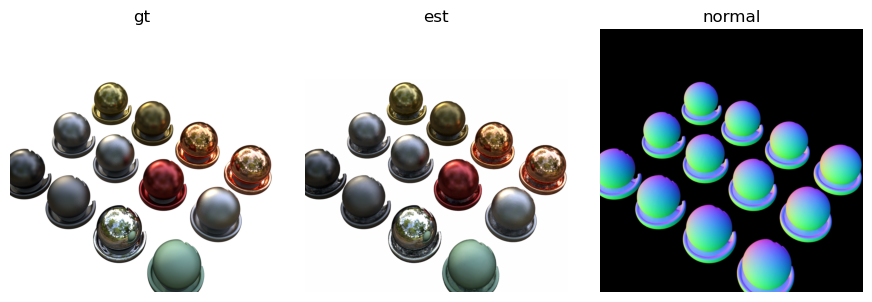

In [6]:
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.imshow(rgbs_gt.reshape(*img_hw,3))
plt.title('gt')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(rgbs)
plt.title('est')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(normals)
plt.axis('off')
plt.title('normal')
plt.tight_layout()

## Visualize real scenes

In [7]:
# dataset
dataset = GlossyRealDataset('../../data/GlossyReal/bunny',split='test')
img_hw = dataset.img_hw

In [8]:
# model
state_dict = torch.load('../outputs/weight/bunny.pth',map_location='cpu')
conf = omegaconf.OmegaConf.load('../configs/real.yaml')
render_step_size = 5e-3

aabb = list(torch.cat([state_dict['model.xyzmin'],state_dict['model.xyzmax']],-1).reshape(-1).numpy())
weight = {}
for k,v in state_dict.items():
    if 'model.' in k:
        weight[k.replace('model.','')] = v       
model = VolSDF(aabb,conf.sdf,conf.nde)
model.load_state_dict(weight)
model.eval()
model.to(device)
for p in model.parameters():
    p.requires_grad=False

estimator = nerfacc.OccGridEstimator(aabb)
weight = {}
for k,v in state_dict.items():
    if 'estimator.' in k:
        weight[k.replace('estimator.','')] = v
estimator.load_state_dict(weight)
estimator.to(device)

estimator2 = MIPOccGridEstimator(aabb,resolution=128,levels=5)
weight = {}
for k,v in state_dict.items():
    if 'estimator2.' in k:
        weight[k.replace('estimator2.','')] = v
estimator2.load_state_dict(weight)
estimator2.to(device)

model.nde.pre_decode=False
model.beta=1e-3
model.nde.render_step_size=render_step_size

In [9]:
# render a novel view
focus = np.array([0,0,0.25]) # lookat point
theta,phi = 60,90 # direction to lookat point
focus_r = 1.9 # distance to lookat point

# w2c matrix
R = Rotation.from_euler('xyz',[theta,0,phi],degrees=True).as_matrix()
t = focus+R[:,-1]*focus_r
w2c = np.concatenate([R.T,-R.T@t.reshape(3,1)],-1)
w2c = np.diag([1,-1,-1,1])@np.concatenate([w2c,np.array([0,0,0,1]).reshape(1,4)],0)

# get rays and near,far plane
rays,near,far,human_pose = dataset._get_rays(torch.from_numpy(w2c[:3,:4]).float())  
xs = rays[...,:3].to(device)
ds = rays[...,3:6].to(device)
near,far = near.to(device),far.to(device)

mode = 0 # (0,1,2) for (all,far-field,near-field) reflection
rgbs = []
normals = []

batch_size = 2000
for b in tqdm(range(math.ceil(len(xs)*1.0/batch_size))):
    b0 = b*batch_size
    b1 = min(b*batch_size+batch_size,len(xs))
    ret = volume_rendering(
            xs[b0:b1], ds[b0:b1], 
            near[b0:b1],far[b0:b1],render_step_size, 
            torch.ones(3,device=device),
            model, estimator, estimator2,
            mode=mode)
    
    if ret is None:
        rgbs.append(torch.ones((b1-b0),3))
        normals.append(torch.zeros((b1-b0),3))
    else:
        rgbs.append(gamma(ret['rgb']).clamp(0,1).cpu())
        normals.append(ret['normal'].cpu())
    torch.cuda.empty_cache()
    
rgbs = torch.cat(rgbs,0).cpu().reshape(*img_hw,3)
normals = torch.cat(normals,0).reshape(*img_hw,3)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 394/394 [00:07<00:00, 49.27it/s]


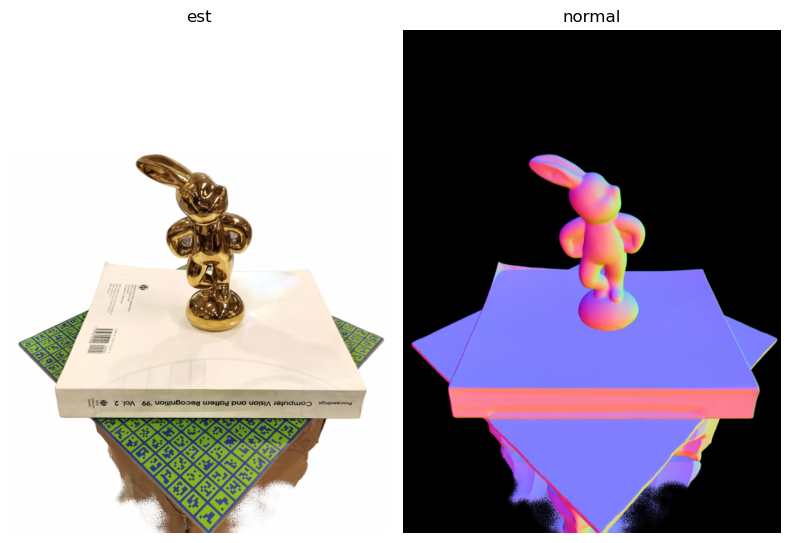

In [10]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(rgbs)
plt.title('est')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(normals)
plt.axis('off')
plt.title('normal')
plt.tight_layout()